In [22]:
import sys
import pystan
import stan_utility
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

ITER = 1000
SEED = 29042020

In [52]:
light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


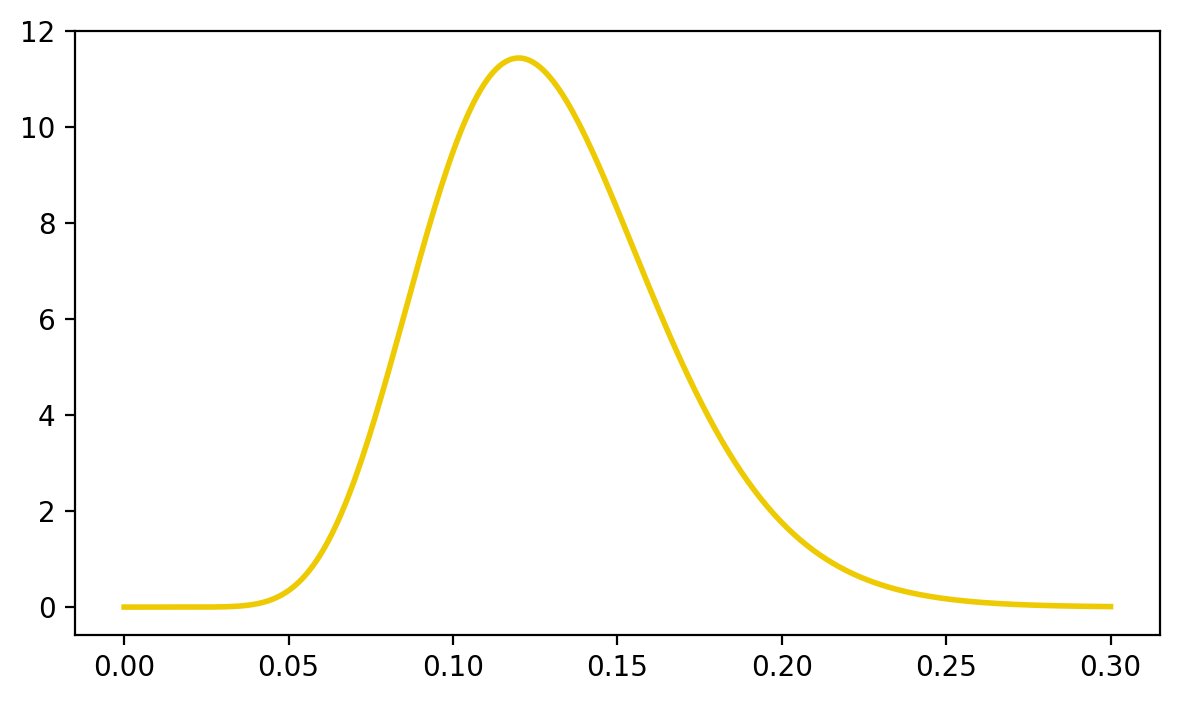

In [53]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
x2=np.linspace(0,0.3,300)
alpha=13
beta=100
axes.plot(x2,stats.gamma.pdf(x2,a=alpha,scale=1/beta),color=dark,linewidth=2)
#axes.set_yticks(())
#axes.set_xticks([0,20/1e5])

plt.show()

In [54]:
with open('airlines_fatal.stan', 'r') as file:
    print(file.read())

data {
  int miles; //miles_flown
}

generated quantities {
real theta = gamma_rng(13,100);
int y = poisson_rng(theta*miles);
}





In [55]:
model_prior=stan_utility.compile_model('airlines_fatal.stan')

Using cached StanModel


In [56]:
sim_data=dict(miles=7500)
sim_ppc=model_prior.sampling(data=sim_data,algorithm="Fixed_param", iter=ITER, warmup=0, chains=1, refresh=ITER,
                     seed=30042020)

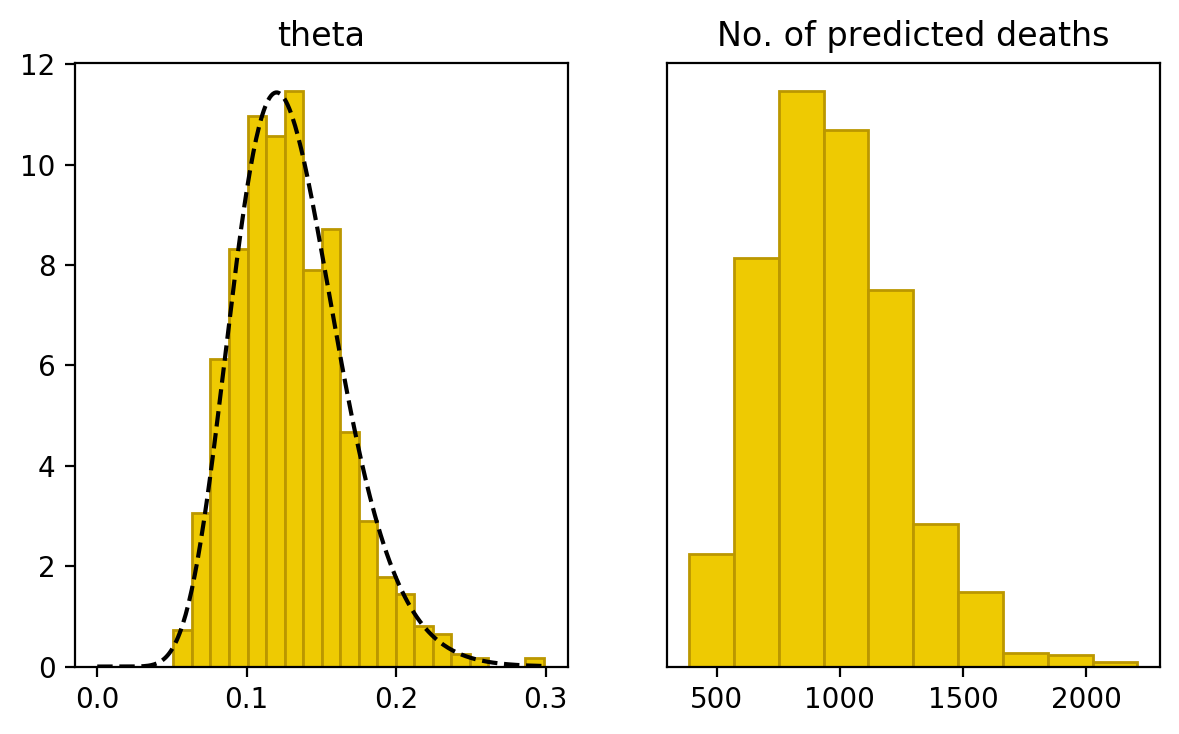

In [57]:
params=sim_ppc.extract()
theta=params['theta']
prior_median=np.median(theta)
S_sim=params['y']
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax1=axes[0]
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.plot(x2,stats.gamma.pdf(x2,a=alpha,scale=1/beta),color='black',linestyle='--')
#ax1.set_xticks([0,20/1e5])
#ax1.set_yticks([])
ax1.set_title('theta')
#ax1.annotate('Prior',xy=(5e-5,stats.gamma.pdf(5e-5,a=alpha,scale=1/beta)),xytext=(1e-4,2e4),arrowprops={'arrowstyle':'->'})
ax2=axes[1]
ax2.hist(S_sim,color=dark,edgecolor=dark_highlight,density=True,bins=10)
#ax2.set_xticks([0,3])
ax2.set_yticks([])
ax2.set_title('No. of predicted deaths')
plt.show()

## Data

In [100]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airlines_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airlines_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airlines_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airlines_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


In [62]:
with open('airlines_fatal_fit_singular.stan', 'r') as file:
    print(file.read())

data {
  int y; //passenger deaths in a given year
  int miles; //miles flown in a given year
}

parameters {
  real<lower=0> theta;//estimated passenger death parameters
}
transformed parameters {
  real<lower=0> lambda= miles * theta;
}

model {
  theta ~ gamma(13,100);
  y ~ poisson(lambda);
}

generated quantities {
  int y_sim=0;
  y_sim = poisson_rng(lambda);
}





In [64]:
model2=stan_utility.compile_model('airlines_fatal_fit_singular.stan')

Using cached StanModel


In [95]:
p_deaths=np.array(Airlines_data['Passenger deaths']).astype('int')
miles=np.array(Airlines_data['Miles flown [100 mln miles]']).astype('int')

In [97]:
k=3
data = dict(y = p_deaths[k],
            miles=miles[k])
fit = model2.sampling(data=data, seed=26042020)

In [77]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [92]:
def estimate_death_rate(p_deaths,miles):
    data = dict(y = np.int(p_deaths),
                miles=np.int(miles))
    fit = model2.sampling(data=data, seed=26042020)
    params=fit.extract()
    pred_dr=np.median(params['theta'])
    pred_dr_err=az.hpd(params['theta'],0.9)
    pred_pd=np.median(params['y_sim'])
    pred_pd_err=az.hpd(params['y_sim'],0.9)
    pred_dr_err_low=pred_dr_err[0]
    pred_dr_err_upp=pred_dr_err[1]
    pred_pd_err_low=pred_pd_err[0]
    pred_pd_err_upp=pred_pd_err[1]
    return pd.Series([pred_dr,
                      pred_pd,
                      pred_dr_err_low,
                      pred_dr_err_upp,
                      pred_pd_err_low,
                      pred_pd_err_upp],
                     index=['pred_dr',
                            'pred_pd',
                            'pred_dr_err_low',
                            'pred_dr_err_upp',
                            'pred_pd_err_low',
                            'pred_pd_err_upp'])

In [98]:
estimate_death_rate(p_deaths[k],miles[k])

pred_dr              0.159219
pred_pd            873.000000
pred_dr_err_low      0.150249
pred_dr_err_upp      0.168680
pred_pd_err_low    802.000000
pred_pd_err_upp    942.000000
dtype: float64

In [101]:
Airlines_data[['pred_dr',
                 'pred_pd',
                 'pred_dr_err_low',
                 'pred_dr_err_upp',
                 'pred_pd_err_low',
                 'pred_pd_err_upp']] = Airlines_data.apply(lambda x: estimate_death_rate(x['Passenger deaths'], x['Miles flown [100 mln miles]']), axis=1)
Airlines_data.to_csv('Airlines_data_with_estimates.csv')
Airlines_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles],pred_dr,pred_pd,pred_dr_err_low,pred_dr_err_upp,pred_pd_err_low,pred_pd_err_upp
Year,,,,,,,,,,
1976,24,734,0.19,3863.0,0.188181,727.0,0.176727,0.199390,668.0,793.0
1977,25,516,0.12,4300.0,0.120201,516.0,0.111241,0.128393,463.0,567.0
1978,31,754,0.15,5027.0,0.149429,752.0,0.140505,0.158367,684.0,810.0
1979,31,877,0.16,5481.0,0.159219,873.0,0.150249,0.168680,802.0,942.0
1980,22,814,0.14,5814.0,0.139723,812.0,0.131919,0.148449,745.0,876.0
1981,21,362,0.06,6033.0,0.061053,369.0,0.055470,0.066139,322.0,410.0
1982,26,764,0.13,5877.0,0.129847,764.0,0.121702,0.137736,695.0,824.0
1983,20,809,0.13,6223.0,0.129940,809.0,0.122970,0.138191,737.0,871.0
1984,16,223,0.03,7433.0,0.031265,233.0,0.027833,0.034659,198.0,267.0
